In [0]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import mpl_toolkits.axes_grid1
import cv2
from keras.applications.inception_v3 import preprocess_input
from keras.applications.inception_v3 import InceptionV3
import fnmatch
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from sklearn import preprocessing
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, concatenate
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers import BatchNormalization
from keras.preprocessing import image
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
import glob
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# Read the images and generate the train and test dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Data directory
root_dir = '/content/drive/My Drive/Colab Notebooks/plant-seedlings-classification'
train_dir = os.path.join(root_dir, 'train')
test_dir = os.path.join(root_dir, 'test')
species = os.listdir(train_dir)
num_species = len(species)

image_path = glob.glob(train_dir + '/*/*.png')
labels = [x.split("/")[-2] for x in image_path]

X = []
for i in image_path:
    img = cv2.imread(i)
    img = cv2.resize(img, (224, 224))
    X.append(img)
    
X = np.array(X).astype(np.float32)
X = X /255

print("X Shape \n", X.shape)

le = LabelEncoder()
lb = LabelBinarizer()

labels = le.fit_transform(labels)
y = lb.fit_transform(labels)

target_names = le.classes_
print("Y Shape \n", y.shape)

print("Target Classes \n", target_names)

# print number of images of each species in the training data
for sp in species:
    print('{} images of {}'.format(len(os.listdir(os.path.join(train_dir, sp))),sp))

X Shape 
 (4775, 224, 224, 3)
Y Shape 
 (4775, 12)
Target Classes 
 ['Black-grass' 'Charlock' 'Cleavers' 'Common Chickweed' 'Common wheat'
 'Fat Hen' 'Loose Silky-bent' 'Maize' 'Scentless Mayweed'
 'Shepherds Purse' 'Small-flowered Cranesbill' 'Sugar beet']
231 images of Shepherds Purse
221 images of Common wheat
287 images of Cleavers
654 images of Loose Silky-bent
496 images of Small-flowered Cranesbill
619 images of Common Chickweed
221 images of Maize
475 images of Fat Hen
516 images of Scentless Mayweed
402 images of Sugar beet
263 images of Black-grass
390 images of Charlock


In [0]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

def segment(img):

  image_mask = create_mask_for_plant(img)
  image_segmented = segment_plant(img)
  image_sharpen = sharpen_image(image_segmented)
  return image_sharpen

for indx, image in enumerate(X):
  try:
     images[indx] = segment(image)
      
  except:
      continue

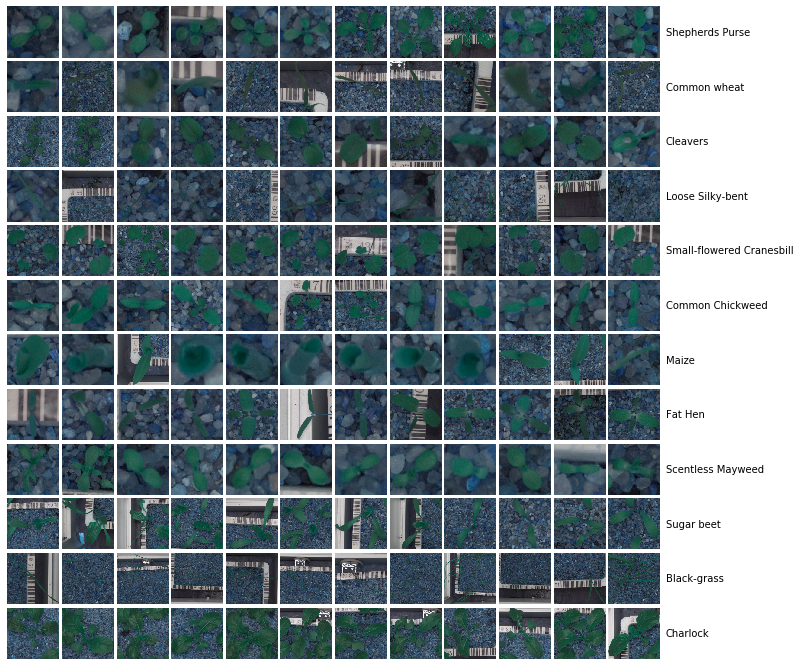

In [0]:
train = []
for species_id, sp in enumerate(species):
    for file in os.listdir(os.path.join(train_dir, sp)):
        train.append(['train/{}/{}'.format(sp, file), file, species_id, sp])
train_df = pd.DataFrame(train, columns=['filepath', 'file', 'species_id', 'species'])
## show 12 images of all species of train data
fig = plt.figure(1, figsize=(num_species, num_species))
grid = mpl_toolkits.axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_species, num_species), 
                                             axes_pad=0.05)
i = 0
for species_id, sp in enumerate(species):
   for filepath in train_df[train_df['species'] == sp]['filepath'].values[:num_species]:
        ax = grid[i]
        img = read_image(filepath, (224, 224))
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
        if i % num_species == num_species - 1:
           ax.text(250, 112, sp, verticalalignment='center')
        i += 1
plt.show();

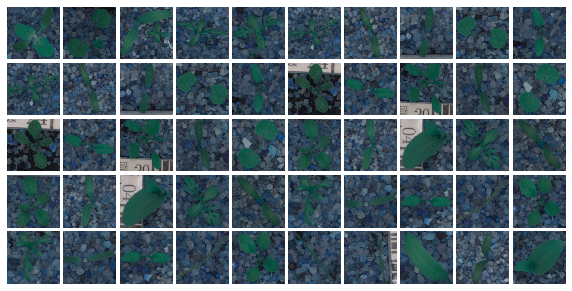

In [0]:
test = []
for file in os.listdir(test_dir):
    test.append(['test/{}'.format(file), file])
test_df = pd.DataFrame(test, columns=['filepath', 'file'])
fig = plt.figure(1, figsize=(10, 10))
grid = mpl_toolkits.axes_grid1.ImageGrid(fig, 111, nrows_ncols=(5, 10), 
                                            axes_pad=0.05)
i = 0
for j in range(5):
    for filepath in test_df['filepath'].values[j*5:j*5+10]:
        ax = grid[i]
        img = read_image(filepath, (224, 224))
        ax.imshow(img.astype(np.uint8))
        ax.axis('off')
        i += 1
plt.show();

In [0]:
# function to read an image 
def read_image(filepath, target_size=None):
    img = cv2.imread(os.path.join(root_dir, filepath), cv2.IMREAD_COLOR)
    img = cv2.resize(img.copy(), target_size, interpolation = cv2.INTER_AREA)
    return img

In [0]:
# train data
print("Train dataset\n")
print(train_df.head())
# test data
print("Test dataset\n")
print(test_df.head())

Train dataset

                              filepath  ...          species
0  train/Shepherds Purse/07f867aa5.png  ...  Shepherds Purse
1  train/Shepherds Purse/05ea7f987.png  ...  Shepherds Purse
2  train/Shepherds Purse/01aef64d2.png  ...  Shepherds Purse
3  train/Shepherds Purse/0ad0ef03e.png  ...  Shepherds Purse
4  train/Shepherds Purse/02afc3d7a.png  ...  Shepherds Purse

[5 rows x 4 columns]
Test dataset

             filepath           file
0  test/03566743d.png  03566743d.png
1  test/03a2ee656.png  03a2ee656.png
2  test/03e322a29.png  03e322a29.png
3  test/05341a8a6.png  05341a8a6.png
4  test/04814f36d.png  04814f36d.png


# Divide the data set into Train and validation data sets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=4750)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.20, random_state=4750)

In [0]:
mean = np.mean(X_train, axis=0)

X_train -= mean
X_valid -= mean
X_test -= mean

for i in [y_train, y_valid, y_test]:
    temp = le.inverse_transform(lb.inverse_transform(i))
    a, b = np.unique(temp, return_counts=True)
    df = pd.DataFrame({"label": a, "count": b})
    print(df)
    print(" ")

                        label  count
0                 Black-grass    166
1                    Charlock    256
2                    Cleavers    173
3            Common Chickweed    417
4                Common wheat    150
5                     Fat Hen    314
6            Loose Silky-bent    418
7                       Maize    147
8           Scentless Mayweed    318
9             Shepherds Purse    148
10  Small-flowered Cranesbill    301
11                 Sugar beet    248
 
                        label  count
0                 Black-grass     50
1                    Charlock     60
2                    Cleavers     50
3            Common Chickweed     82
4                Common wheat     35
5                     Fat Hen     82
6            Loose Silky-bent     93
7                       Maize     37
8           Scentless Mayweed     90
9             Shepherds Purse     30
10  Small-flowered Cranesbill     79
11                 Sugar beet     76
 
                        label  cou

In [0]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(3056, 224, 224, 3)
(3056, 12)
(764, 224, 224, 3)
(764, 12)
(955, 224, 224, 3)
(955, 12)


# Initialize & build the model

In [0]:
model1 = Sequential()
model1.add(Conv2D(32,(3, 3),
                 activation='relu',
                 input_shape=(224,224,3)))
model1.add(MaxPooling2D(pool_size=(1, 1)))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))

model1.add(Conv2D(32, (1, 1), activation='relu'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size=(1, 1)))
model1.add(Dropout(0.25))

model1.add(Flatten())

model1.add(Dense(128, activation='relu'))
model1.add(BatchNormalization())
model1.add(Dropout(0.25))
model1.add(Dense(12, activation='softmax'))

model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Train on 3056 samples, validate on 764 samples
Epoch 1/10
3056/3056 [==============================] - 3s 1ms/step - loss: 0.0503 - acc: 0.9892 - val_loss: 1.0363 - val_acc: 0.7173
Epoch 2/10
3056/3056 [==============================] - 3s 1ms/step - loss: 0.0265 - acc: 0.9977 - val_loss: 1.0920 - val_acc: 0.7304
Epoch 3/10
3056/3056 [==============================] - 3s 1ms/step - loss: 0.0747 - acc: 0.9813 - val_loss: 1.1026 - val_acc: 0.7382
Epoch 4/10
3056/3056 [==============================] - 3s 1ms/step - loss: 0.0387 - acc: 0.9925 - val_loss: 1.0108 - val_acc: 0.7238
Epoch 5/10
3056/3056 [==============================] - 3s 1ms/step - loss: 0.0332 - acc: 0.9925 - val_loss: 1.3299 - val_acc: 0.7055
Epoch 6/10
3056/3056 [==============================] - 3s 1ms/step - loss: 0.0509 - acc: 0.9866 - val_loss: 1.1983 - val_acc: 0.7042
Epoch 7/10
3056/3056 [==============================] - 3s 1ms/step - loss: 0.0502 - acc: 0.9869 - val_loss: 1.0359 - val_acc: 0.7343
Epoch 8/10
3056

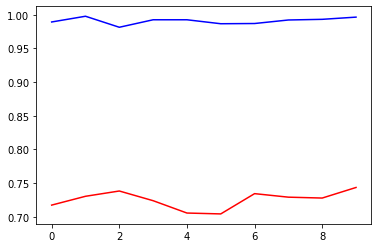

In [0]:
#Fit the model on the above architecture. 
log1 = model1.fit(X_train, y_train, epochs=10, batch_size=50, validation_data = (X_valid, y_valid))

# Final evaluation of the model
scores1 = model1.evaluate(X_train, y_train, verbose=0)
print("Model Error: %.2f%%" % (100-scores[1]*100))

#plot model
plt.plot(log1.history['acc'],'b') 
plt.plot(log1.history['val_acc'],'r')
plt.show()

# Optimize the model

* tried Learning rate 0.1,0.01,0.001,0.0001 best accuracy was achieved by 0.001
* tried optimizers sgd,adam,rmsprop, best accuracy was achieved by adam
* added more conv and dense layers and increased filters & filter size
* increased dropouts size

In [0]:
model2 = Sequential()

model2.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(224, 224, 3), activation='relu'))
model2.add(BatchNormalization(axis=3))
model2.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization(axis=3))
model2.add(Dropout(0.12))

model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization(axis=3))
model2.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization(axis=3))
model2.add(Dropout(0.12))

model2.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model2.add(BatchNormalization(axis=3))
model2.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model2.add(MaxPooling2D((2, 2)))
model2.add(BatchNormalization(axis=3))
model2.add(Dropout(0.12))

model2.add(Flatten())

model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(256, activation='relu'))
model2.add(BatchNormalization())
model2.add(Dropout(0.25))

model2.add(Dense(num_species, activation='softmax'))

model2.summary()

# compile model
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_23 (Conv2D)           (None, 222, 222, 64)      1792      
_________________________________________________________________
batch_normalization_35 (Batc (None, 222, 222, 64)      256       
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 220, 220, 64)      36928     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 110, 110, 64)      0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 110, 110, 64)      256       
_________________________________________________________________
dropout_32 (Dropout)         (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 108, 108, 128)   

Train on 3056 samples, validate on 764 samples
Epoch 1/25
3056/3056 [==============================] - 22s 7ms/step - loss: 0.0327 - acc: 0.9915 - val_loss: 0.7854 - val_acc: 0.8416
Epoch 2/25
3056/3056 [==============================] - 22s 7ms/step - loss: 0.0144 - acc: 0.9964 - val_loss: 0.7345 - val_acc: 0.8508
Epoch 3/25
3056/3056 [==============================] - 22s 7ms/step - loss: 0.0514 - acc: 0.9849 - val_loss: 0.7359 - val_acc: 0.8469
Epoch 4/25
3056/3056 [==============================] - 22s 7ms/step - loss: 0.0398 - acc: 0.9912 - val_loss: 0.6868 - val_acc: 0.8560
Epoch 5/25
3056/3056 [==============================] - 22s 7ms/step - loss: 0.0600 - acc: 0.9807 - val_loss: 0.8228 - val_acc: 0.8259
Epoch 6/25
3056/3056 [==============================] - 22s 7ms/step - loss: 0.0293 - acc: 0.9921 - val_loss: 0.6930 - val_acc: 0.8390
Epoch 7/25
3056/3056 [==============================] - 22s 7ms/step - loss: 0.0243 - acc: 0.9931 - val_loss: 0.6462 - val_acc: 0.8547
Epoch 8/

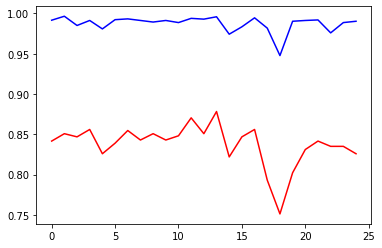

In [0]:
#Fit the model on the above architecture. 
log2 = model2.fit(X_train, y_train, epochs=25, batch_size=50, validation_data = (X_valid, y_valid))

# Final evaluation of the model
scores2 = model2.evaluate(X_train, y_train, verbose=0)
print("Model Error: %.2f%%" % (100-scores2[1]*100))

#plot model
plt.plot(log2.history['acc'],'b') 
plt.plot(log2.history['val_acc'],'r')
plt.show()

In [0]:
datagen = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range=0.2,
    zoom_range=0.3,
    vertical_flip=True,
    horizontal_flip=True,
    fill_mode = 'nearest')

BATCH_SIZE = 50
EPOCHS = 10
datagen.fit(X_train)


history = model2.fit_generator(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE), 
                             epochs=EPOCHS, 
                             steps_per_epoch=10*len(X_train)/BATCH_SIZE,
                             validation_data = (X_valid, y_valid))

#final eval
train_acc = model2.evaluate(X_train, y_train, verbose=0)
print("Model Error: %.2f%%" % (100-train_acc[1]*100))

Epoch 1/10
612/611 [==============================] - 316s 516ms/step - loss: 1.0644 - acc: 0.6625 - val_loss: 0.4976 - val_acc: 0.8272
Epoch 2/10
612/611 [==============================] - 314s 514ms/step - loss: 0.5631 - acc: 0.8022 - val_loss: 0.3489 - val_acc: 0.8626
Epoch 3/10
612/611 [==============================] - 313s 512ms/step - loss: 0.4606 - acc: 0.8418 - val_loss: 0.7519 - val_acc: 0.7356
Epoch 4/10
612/611 [==============================] - 313s 512ms/step - loss: 0.3772 - acc: 0.8686 - val_loss: 0.2725 - val_acc: 0.9045
Epoch 5/10
612/611 [==============================] - 313s 511ms/step - loss: 0.3377 - acc: 0.8868 - val_loss: 0.2443 - val_acc: 0.9202
Epoch 6/10
612/611 [==============================] - 315s 515ms/step - loss: 0.2992 - acc: 0.8964 - val_loss: 0.3374 - val_acc: 0.8901
Epoch 7/10
612/611 [==============================] - 313s 512ms/step - loss: 0.2951 - acc: 0.8987 - val_loss: 0.2372 - val_acc: 0.9228
Epoch 8/10
612/611 [============================

# Predict the accuracy for both train and validation data

In [0]:
training_predictions = model2.predict(X_train)
training_predictions = np.argmax(training_predictions, axis=-1)
print(classification_report(lb.inverse_transform(y_train), training_predictions, target_names=le.classes_))
print("Training Accuracy: {:.3f}".format(accuracy_score(lb.inverse_transform(y_train), training_predictions)))

                           precision    recall  f1-score   support

              Black-grass       0.49      0.86      0.62       166
                 Charlock       0.94      0.98      0.96       256
                 Cleavers       0.83      0.98      0.90       173
         Common Chickweed       0.98      0.89      0.93       417
             Common wheat       0.83      0.98      0.90       150
                  Fat Hen       1.00      0.95      0.97       314
         Loose Silky-bent       0.96      0.62      0.75       418
                    Maize       1.00      0.95      0.97       147
        Scentless Mayweed       0.94      0.94      0.94       318
          Shepherds Purse       0.77      0.80      0.78       148
Small-flowered Cranesbill       0.97      0.98      0.98       301
               Sugar beet       0.93      0.95      0.94       248

                 accuracy                           0.89      3056
                macro avg       0.89      0.91      0.89    

In [0]:
validation_predictions = model2.predict(X_valid)
validation_predictions = np.argmax(validation_predictions, axis=-1)
print(classification_report(lb.inverse_transform(y_valid), validation_predictions, target_names=le.classes_))
print("Validation Accuracy: {:.3f}".format(accuracy_score(lb.inverse_transform(y_valid), validation_predictions)))

                           precision    recall  f1-score   support

              Black-grass       0.49      0.74      0.59        50
                 Charlock       0.82      1.00      0.90        60
                 Cleavers       0.82      0.94      0.88        50
         Common Chickweed       0.96      0.84      0.90        82
             Common wheat       0.77      0.94      0.85        35
                  Fat Hen       0.99      0.93      0.96        82
         Loose Silky-bent       0.93      0.55      0.69        93
                    Maize       0.97      0.89      0.93        37
        Scentless Mayweed       0.89      0.97      0.93        90
          Shepherds Purse       0.79      0.73      0.76        30
Small-flowered Cranesbill       0.95      0.94      0.94        79
               Sugar beet       0.91      0.88      0.89        76

                 accuracy                           0.86       764
                macro avg       0.86      0.86      0.85    


Calculating Train Set accuracy ...
3056/3056 [==============================] - 8s 3ms/step
Train Set accuracy: [28.79, 89.14]%

Calculating Valid Set accuracy ...
764/764 [==============================] - 2s 3ms/step
Valid Set accuracy: [39.85, 85.86]%


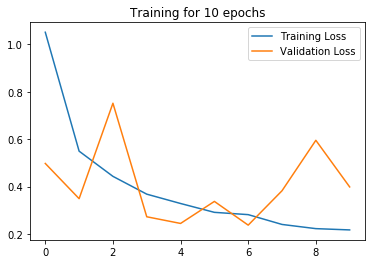

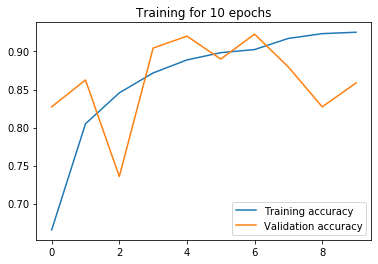

In [0]:
# # Evaluate on train and valid set
print('\nCalculating Train Set accuracy ...')
train_acc = model2.evaluate(X_train,y_train)
print('Train Set accuracy: {}%'.format([np.round(acc * 100, 2) for acc in train_acc]))
print('\nCalculating Valid Set accuracy ...')
valid_acc = model2.evaluate(X_valid,y_valid)
print('Valid Set accuracy: {}%'.format([np.round(acc * 100, 2) for acc in valid_acc]))
  
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training for ' +str(EPOCHS)+ ' epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Training for ' +str(EPOCHS)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

In [0]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
        heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
        heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")

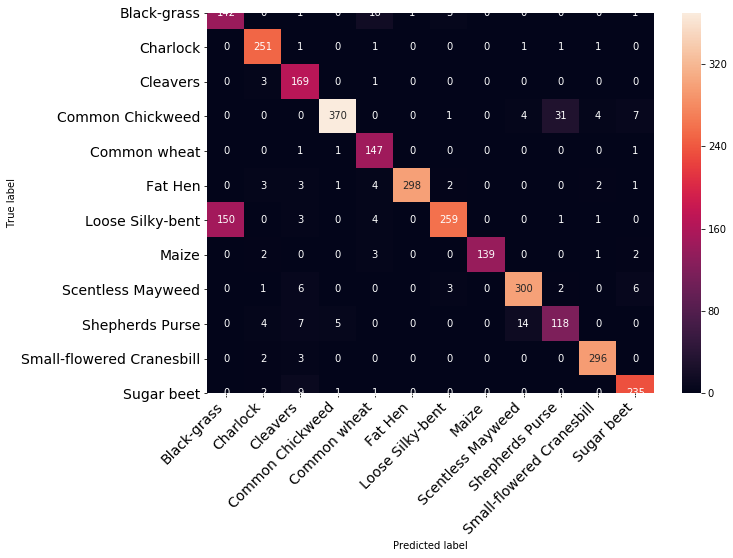

In [0]:
cm = confusion_matrix(lb.inverse_transform(y_train), training_predictions)
print_confusion_matrix(cm,le.classes_)

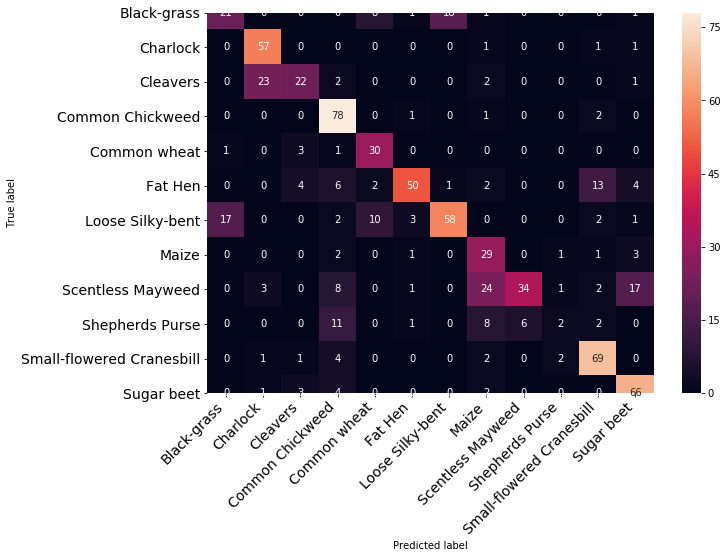

In [0]:
cm = confusion_matrix(lb.inverse_transform(y_valid), validation_predictions)
print_confusion_matrix(cm,le.classes_)

# Use transfer learning method and build a model

In [0]:
# Inception_V3 Model
img_rows, img_cols, img_depths = 224, 224, 3
def Inception_V3(img_rows, img_cols, img_depths):
    base_model = InceptionV3(include_top=False, input_shape=(img_rows,img_cols,img_depths), pooling='avg', weights="imagenet")
    model = base_model.output
    # Add a new Dense layer to fully connect the node
    model = Dense(4096, activation='relu')(model)
    # Add a new Dense layer to output 12 classes
    # Initialize the weight with Xavier Normal Initialization
    prediction = Dense(12, activation='softmax', kernel_initializer='glorot_normal')(model)
    model = Model(base_model.input, prediction)

    print('model loading finished succesfully')    

    return model

Inception_Model = Inception_V3(img_rows, img_cols, img_depths)
Inception_Model.summary()

model loading finished succesfully
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_207 (Conv2D)             (None, 111, 111, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_207 (BatchN (None, 111, 111, 32) 96          conv2d_207[0][0]                 
__________________________________________________________________________________________________
activation_206 (Activation)     (None, 111, 111, 32) 0           batch_normalization_207[0][0]    
_________________________________________________________

In [0]:
learning_rate = 0.0025
from keras.optimizers import SGD, Adam, RMSprop
sgd = SGD(lr=learning_rate, momentum=0.9, nesterov=True)
# Compile model 
Inception_Model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
print('model compilation finished succesfully')

model compilation finished succesfully


In [0]:
from keras.callbacks import EarlyStopping
epochs = 20
batch_size = 32
earlystopper = EarlyStopping(monitor='val_acc', min_delta=0, patience=4, verbose=0, mode='auto', baseline=None)
Inception_Model.fit(X_train, y_train, validation_data= (X_valid, y_valid), epochs=epochs, batch_size=batch_size, callbacks=[earlystopper], verbose=1)

Train on 3056 samples, validate on 764 samples
Epoch 1/20
3056/3056 [==============================] - 48s 16ms/step - loss: 1.2715 - acc: 0.6139 - val_loss: 0.5144 - val_acc: 0.8272
Epoch 2/20
3056/3056 [==============================] - 21s 7ms/step - loss: 0.2411 - acc: 0.9238 - val_loss: 0.2497 - val_acc: 0.9149
Epoch 3/20
3056/3056 [==============================] - 21s 7ms/step - loss: 0.1114 - acc: 0.9630 - val_loss: 0.2109 - val_acc: 0.9411
Epoch 4/20
3056/3056 [==============================] - 21s 7ms/step - loss: 0.0486 - acc: 0.9863 - val_loss: 0.1833 - val_acc: 0.9437
Epoch 5/20
3056/3056 [==============================] - 21s 7ms/step - loss: 0.0377 - acc: 0.9882 - val_loss: 0.2247 - val_acc: 0.9372
Epoch 6/20
3056/3056 [==============================] - 21s 7ms/step - loss: 0.0289 - acc: 0.9918 - val_loss: 0.1738 - val_acc: 0.9490
Epoch 7/20
3056/3056 [==============================] - 21s 7ms/step - loss: 0.0203 - acc: 0.9961 - val_loss: 0.1949 - val_acc: 0.9411
Epoch 8

In [0]:
training_predictions = Inception_Model.predict(X_train)
training_predictions = np.argmax(training_predictions, axis=-1)
print(classification_report(lb.inverse_transform(y_train), training_predictions, target_names=le.classes_))
print("Training Accuracy: {:.3f}".format(accuracy_score(lb.inverse_transform(y_train), training_predictions)))

                           precision    recall  f1-score   support

              Black-grass       1.00      1.00      1.00       166
                 Charlock       1.00      1.00      1.00       256
                 Cleavers       1.00      1.00      1.00       173
         Common Chickweed       1.00      1.00      1.00       417
             Common wheat       1.00      1.00      1.00       150
                  Fat Hen       1.00      1.00      1.00       314
         Loose Silky-bent       1.00      1.00      1.00       418
                    Maize       1.00      1.00      1.00       147
        Scentless Mayweed       1.00      1.00      1.00       318
          Shepherds Purse       1.00      0.99      1.00       148
Small-flowered Cranesbill       1.00      1.00      1.00       301
               Sugar beet       1.00      1.00      1.00       248

                 accuracy                           1.00      3056
                macro avg       1.00      1.00      1.00    

In [0]:
validation_predictions = Inception_Model.predict(X_valid)
validation_predictions = np.argmax(validation_predictions, axis=-1)
print(classification_report(lb.inverse_transform(y_valid), validation_predictions, target_names=le.classes_))
print("Validation Accuracy: {:.3f}".format(accuracy_score(lb.inverse_transform(y_valid), validation_predictions)))

                           precision    recall  f1-score   support

              Black-grass       0.83      0.76      0.79        50
                 Charlock       0.98      1.00      0.99        60
                 Cleavers       0.98      0.94      0.96        50
         Common Chickweed       0.94      1.00      0.97        82
             Common wheat       0.92      0.94      0.93        35
                  Fat Hen       0.95      1.00      0.98        82
         Loose Silky-bent       0.90      0.90      0.90        93
                    Maize       0.95      1.00      0.97        37
        Scentless Mayweed       0.98      0.97      0.97        90
          Shepherds Purse       0.96      0.73      0.83        30
Small-flowered Cranesbill       0.95      0.97      0.96        79
               Sugar beet       0.97      0.96      0.97        76

                 accuracy                           0.95       764
                macro avg       0.94      0.93      0.94    

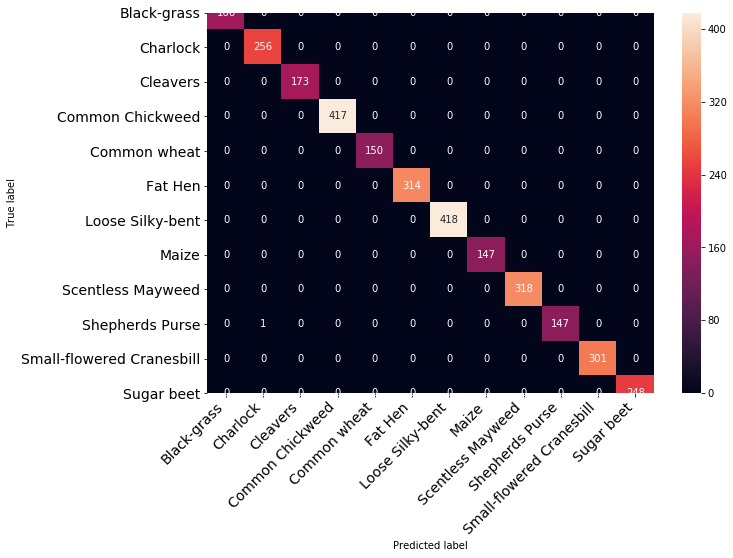

In [0]:
cm = confusion_matrix(lb.inverse_transform(y_train), training_predictions)
print_confusion_matrix(cm,le.classes_)

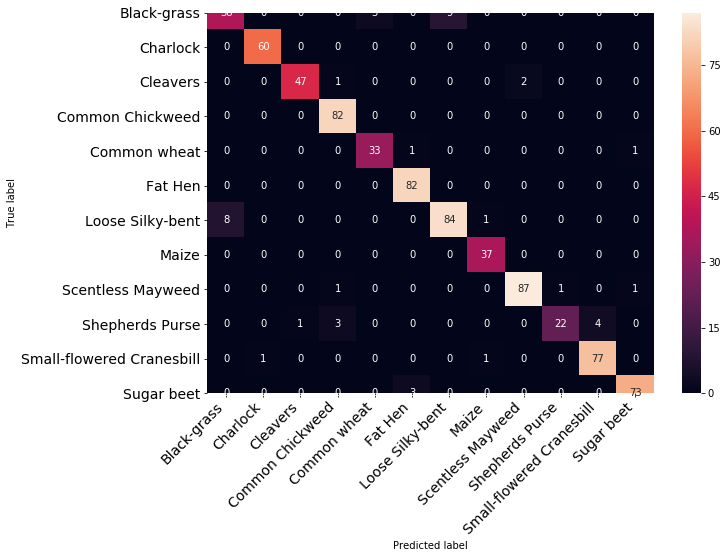

In [0]:
cm = confusion_matrix(lb.inverse_transform(y_valid), validation_predictions)
print_confusion_matrix(cm,le.classes_)


Calculating Train Set accuracy ...
3056/3056 [==============================] - 6s 2ms/step
Train Set accuracy: [0.22, 99.97]%

Calculating Valid Set accuracy ...
764/764 [==============================] - 2s 3ms/step
Valid Set accuracy: [20.23, 94.5]%


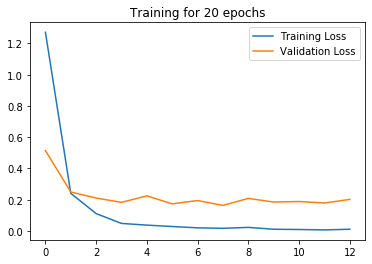

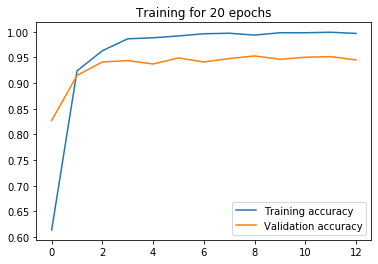

In [0]:
# # Evaluate on train and valid set
print('\nCalculating Train Set accuracy ...')
train_acc = Inception_Model.evaluate(X_train,y_train)
print('Train Set accuracy: {}%'.format([np.round(acc * 100, 2) for acc in train_acc]))
print('\nCalculating Valid Set accuracy ...')
valid_acc = Inception_Model.evaluate(X_valid,y_valid)
print('Valid Set accuracy: {}%'.format([np.round(acc * 100, 2) for acc in valid_acc]))
  
plt.plot(Inception_Model.history.history['loss'])
plt.plot(Inception_Model.history.history['val_loss'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')
plt.show()

plt.plot(Inception_Model.history.history['acc'])
plt.plot(Inception_Model.history.history['val_acc'])
plt.title('Training for ' +str(epochs)+ ' epochs')
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')
plt.show()

In [0]:
testing_predictions = Inception_Model.predict(X_test)
testing_predictions = np.argmax(testing_predictions, axis=-1)
print(classification_report(lb.inverse_transform(y_test), testing_predictions, target_names=le.classes_))
print("Testing Accuracy: {:.3f}".format(accuracy_score(lb.inverse_transform(y_test), testing_predictions)))

                           precision    recall  f1-score   support

              Black-grass       0.57      0.49      0.53        47
                 Charlock       0.99      0.99      0.99        74
                 Cleavers       0.98      0.97      0.98        64
         Common Chickweed       0.95      0.98      0.97       120
             Common wheat       0.85      0.94      0.89        36
                  Fat Hen       0.97      0.96      0.97        79
         Loose Silky-bent       0.85      0.90      0.87       143
                    Maize       0.97      0.97      0.97        37
        Scentless Mayweed       0.92      0.96      0.94       108
          Shepherds Purse       0.98      0.85      0.91        53
Small-flowered Cranesbill       1.00      0.98      0.99       116
               Sugar beet       0.99      0.96      0.97        78

                 accuracy                           0.93       955
                macro avg       0.92      0.91      0.92    

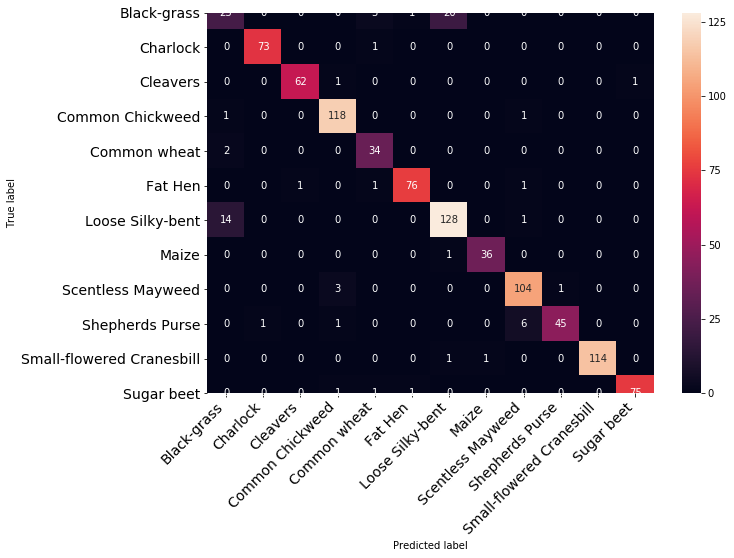

In [0]:
cm = confusion_matrix(lb.inverse_transform(y_test), testing_predictions)
print_confusion_matrix(cm,le.classes_)

In [0]:
prob=[]
num=[]
test_img=[]
test_all = fnmatch.filter(os.listdir(test_dir), '*.png')

test_img=[]
for i in range(len(test_all)):
    path=test_dir+'/'+test_all[i]
    temp_img=image.load_img(path,target_size=(224,224))
    temp_img=image.img_to_array(temp_img)
    test_img.append(temp_img) 
test_img=np.array(test_img)    
test_img=preprocess_input(test_img)



test_labels=[]
pred=Inception_Model.predict(test_img)
num2label =  {0:'Loose Silky-bent', 1:'Charlock',2: 'Sugar beet',3: 'Small-flowered Cranesbill',
              4:'Common Chickweed',5: 'Common wheat',6: 'Maize', 7:'Cleavers', 8:'Scentless Mayweed',
             9: 'Fat Hen', 10:'Black-grass', 11:'Shepherds Purse'}
for i in range(len(test_all)):
    max_score =0
    lab=-1
    for j in range(12):
        if pred[i][j]>max_score:
            max_score=pred[i][j]
            lab=j
    test_labels.append(num2label[lab])


d = {'file': test_all, 'species': test_labels}
df = pd.DataFrame(data=d)
print(df.head(5))


            file           species
0  03566743d.png  Loose Silky-bent
1  03a2ee656.png  Loose Silky-bent
2  03e322a29.png  Loose Silky-bent
3  05341a8a6.png  Loose Silky-bent
4  04814f36d.png  Loose Silky-bent


In [0]:
#Convert dataframe to csv
df.to_csv("submit.csv",index=False)

In [0]:
#Submit the csv
print('Submitting csv')
# submit the file to kaggle
!kaggle competitions submit plant-seedlings-classification -f submit.csv -m "Submitted my file through the Google Colab!"

Submitting csv
100% 23.7k/23.7k [00:03<00:00, 6.79kB/s]
Successfully submitted to Plant Seedlings Classification

# Compare the results of above models

* A very basic CNN model1 as described in section 3 did the best in terms of train accuracy but not with validation accuracy so resulted in overfitting. A more involved CNN model2 with extra layers produced the best accuracy. I found that increasing layers did increase accuracy, but generally at the expense of overfitting although it increased the validation accuracy. After tuning few hyper prameters such as learning rate,optimizers for the model , I was able to see better accuracy overall and less overfitting. Early stopping proved to be very useful when running multiple models, but I found I had to use a high patience number such as 10 because of the wild swings in my model it was possible that it would still produce gains after 4 epochs.

* The Inception model was used from transfer learning mechanism which gave me almost perfect training accuracy, very good validation accuracy and test accuracy lot of trouble in that it wouldn't work with a high learning rate (.01) so tried with 0.0025, epochs of 20 and batch size of 32. It seems like the model needed a smaller learning rate and larger batch size for it to work. In the end, the inception model gave me 93% test accuracy which was close to the best that I achieved with the CNN model2.